## Part 9 - Random Forest

In [67]:
import pip 
pip.main(["install","matplotlib"]) 

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


0

In [68]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in c:\python39\lib\site-packages (1.1.2)


You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [69]:
!pip install xgboost
from xgboost import XGBRegressor

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [70]:
# Chargement des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [71]:
# Chargement de la dataset
## Choix de 4 datasets, ne pas oublier de choisir la features_list adéquate

#dataset = pd.read_csv("dataset_CV_labelise_features1_100.csv", delimiter = ";", encoding = "utf-8") ## 100CV + 4 features numériques

#dataset = pd.read_csv("dataset_CV_labelise_features1_200.csv", delimiter = ";", encoding = "utf-8") ## 200CV + 4 features numériques

#dataset = pd.read_csv("dataset_CV_labelise_features2_100.csv", delimiter = ";", encoding = "utf-8") ## 100CV + 12 features numériques

dataset = pd.read_csv("dataset_CV_labelise_features2_200.csv", delimiter = ";", encoding = "utf-8") ## 200CV + 12 features numériques

In [72]:
dataset.shape

(5594, 19)

In [73]:
data_desc = dataset.describe(include='all')
display(data_desc)

,CV_Sentences,Sentences_CV_clean,CV_Number,Sentence_line,Nb_tokens,%texte_lu,%texte_lu_fin_ligne,Is_alpha,Grammar,Tokenization,Verb_count,Propn_count,Noun_count,Num_count,Pourcentage_verb_sentence,Pourcentage_propn_sentence,Pourcentage_noun_sentence,Pourcentage_num_sentence,Label
count,5594,5592,5594,5594.000000,5594.000000,5594.000000,5594.000000,5594,5594,5592,5594.000000,5594.000000,5594.00000,5594.000000,5594.000000,5594.000000,5594.000000,5594.000000,5594.000000
unique,3805,3802,200,NaN,NaN,NaN,NaN,1626,2748,3802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,,,CV_10,NaN,NaN,NaN,NaN,[False],['NOUN'],,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,198,198,66,NaN,NaN,NaN,NaN,638,334,198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,15.673221,9.132285,50.470518,49.529483,NaN,NaN,NaN,0.297283,0.611012,2.83822,0.320164,0.020117,0.105039,0.314979,0.042982,0.031105
std,NaN,NaN,NaN,11.268076,10.914849,30.190027,30.190025,NaN,NaN,NaN,0.784780,1.129198,3.56600,0.693458,0.059959,0.227969,0.251108,0.131906,0.173616
min,NaN,NaN,NaN,0.000000,1.000000,0.240000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,7.000000,2.000000,24.190000,23.552500,NaN,NaN,NaN,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000
50%,NaN,NaN,NaN,14.000000,5.000000,49.530000,50.470000,NaN,NaN,NaN,0.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.307692,0.000000,0.000000
75%,NaN,NaN,NaN,23.000000,12.000000,76.447500,75.810000,NaN,NaN,NaN,0.000000,1.000000,4.00000,0.000000,0.000000,0.102564,0.416667,0.000000,0.000000


In [74]:
display(100*dataset.isnull().sum()/dataset.shape[0])

CV_Sentences                  0.000000
Sentences_CV_clean            0.035753
CV_Number                     0.000000
Sentence_line                 0.000000
Nb_tokens                     0.000000
%texte_lu                     0.000000
%texte_lu_fin_ligne           0.000000
Is_alpha                      0.000000
Grammar                       0.000000
Tokenization                  0.035753
Verb_count                    0.000000
Propn_count                   0.000000
Noun_count                    0.000000
Num_count                     0.000000
Pourcentage_verb_sentence     0.000000
Pourcentage_propn_sentence    0.000000
Pourcentage_noun_sentence     0.000000
Pourcentage_num_sentence      0.000000
Label                         0.000000
dtype: float64

Préprocessing

In [75]:
# Vérifier des valeurs de la colonne label
dataset["Label"].unique()

array([1, 0], dtype=int64)

In [76]:
# Suppression des lignes de CV_Sentences avec les '#NOM?'
dataset = dataset.loc[(dataset['CV_Sentences'] != "#NOM?"),:]
dataset.shape

(5416, 19)

In [77]:
# Suppression des lignes de CV_Sentences avec ':'
dataset = dataset.loc[(dataset['CV_Sentences'] != ":"),:]
dataset.shape

(5412, 19)

In [78]:
# Suppresion des lignes sans valeur (avec NaN)
dataset = dataset.dropna(axis =0, how = 'any')
dataset.shape

(5410, 19)

In [79]:
# Vérification de la présence des valeurs 'Null' dans la dataset
display(100*dataset.isnull().sum()/dataset.shape[0])

CV_Sentences                  0.0
Sentences_CV_clean            0.0
CV_Number                     0.0
Sentence_line                 0.0
Nb_tokens                     0.0
%texte_lu                     0.0
%texte_lu_fin_ligne           0.0
Is_alpha                      0.0
Grammar                       0.0
Tokenization                  0.0
Verb_count                    0.0
Propn_count                   0.0
Noun_count                    0.0
Num_count                     0.0
Pourcentage_verb_sentence     0.0
Pourcentage_propn_sentence    0.0
Pourcentage_noun_sentence     0.0
Pourcentage_num_sentence      0.0
Label                         0.0
dtype: float64

Application du modèle Random Forest

In [80]:
dataset.head(2)

,CV_Sentences,Sentences_CV_clean,CV_Number,Sentence_line,Nb_tokens,%texte_lu,%texte_lu_fin_ligne,Is_alpha,Grammar,Tokenization,Verb_count,Propn_count,Noun_count,Num_count,Pourcentage_verb_sentence,Pourcentage_propn_sentence,Pourcentage_noun_sentence,Pourcentage_num_sentence,Label
0,SELMA LAFKIR CORDE 80 CODEUSE ENTHOUSIASTE,SELMA LAFKIR CORDE 80 CODEUSE ENTHOUSIASTE,CV_1,0,6,2.80,97.20,"[True, True, True, False, True, True]","['NOUN', 'PROPN', 'VERB', 'NUM', 'PROPN', 'PRO...",SELMA LAFKIR CORDE 80 CODEUSE ENTHOUSIASTE,1,3,1,1,0.166667,0.5,0.166667,0.166667,1
1,PROFIL,PROFIL,CV_1,1,1,3.27,96.73,[True],['NOUN'],PROFIL,0,0,1,0,0.000000,0.0,1.000000,0.000000,0


In [81]:
# Separate target variable Y from features X
print("Separating labels from features...")

## Choisir la features_list par rapport au dataset
#features_list = ["CV_Sentences","Sentences_CV_clean","CV_Number", "Is_alpha", "Grammar", "Label"] ## Pour les datasets features1
features_list = ["CV_Sentences","Sentences_CV_clean","CV_Number", "Is_alpha", "Label", "Grammar", "Tokenization"] ## Pour les datasets features2
target_variable = "Label"

X = dataset.drop(features_list, axis = 1)
y = dataset.loc[:,target_variable]

print('y : ')
print(y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
y : 
0    1
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

X :
   Sentence_line  Nb_tokens  %texte_lu  %texte_lu_fin_ligne  Verb_count  \
0              0          6       2.80                97.20           1   
1              1          1       3.27                96.73           0   
2              2          8       7.01                92.99           0   
3              3         24      18.22                81.78           5   
4              4          1      18.69                81.31           0   

   Propn_count  Noun_count  Num_count  Pourcentage_verb_sentence  \
0            3           1          1                   0.166667   
1            0           1          0                   0.000000   
2            1           2          0                   0.000000   
3            1           5          1                   0.208333   
4            0           1          0                   0.000000   

   Pourcentage_propn_sentence  Pou

In [82]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Sentence_line', 'Nb_tokens', '%texte_lu', '%texte_lu_fin_ligne', 'Verb_count', 'Propn_count', 'Noun_count', 'Num_count', 'Pourcentage_verb_sentence', 'Pourcentage_propn_sentence', 'Pourcentage_noun_sentence', 'Pourcentage_num_sentence']
Found categorical features  []


In [83]:
# Divide dataset Train set & Test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [84]:
# Create pipeline for numeric features
numeric_transformer = SimpleImputer(strategy='mean')

In [85]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first')

In [86]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Grid Search

In [87]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 40}
Best validation accuracy :  0.9798986546559364


In [88]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [89]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [90]:
# Print scores
print("accuracy on training set : ", accuracy_score(y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))                              
print()

accuracy on training set :  0.982902033271719
accuracy on test set :  0.9805914972273567

f1-score on training set :  0.689075630252101
f1-score on test set :  0.6666666666666665



Sauvegarder résultat pour Streamlit

In [91]:
import pickle

In [92]:
filename = 'finalized_model'
pickle.dump(gridsearch, open(filename, 'wb'))

In [93]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(result)

[0 0 0 ... 0 0 0]


In [94]:
loaded_model.predict(np.array([0, 6, 2.8, 97.2, 1, 3, 1, 1, 0.5, 1, 1, 1]).reshape(1, -1))

c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [95]:
loaded_model.predict(np.array([1, 2, 2.8, 97.2, 0, 2, 0, 0, 0, 1, 0, 0]).reshape(1, -1))

c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [99]:
## Choisir la features_list par rapport au dataset
feature = "Sentences_CV_clean"
target_variable = "Label"

X = dataset.loc[:,feature]
Y = dataset.loc[:,target_variable]

## Split train pour obtenir uniquement les test avec le random 42
_ , X_test, _, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)

## Création d'un dataframe pour accueillir les prédictions 
dataset_pred = pd.DataFrame()

## Création des colonnes avec les valeurs correspondantes dans la dataset_pred
dataset_pred['Sentences_CV_clean'] = X_test
dataset_pred['True_Label'] = Y_test
dataset_pred['Label_Pred'] = Y_test_pred

## Ajout de la colonne ["Diff"] pour visualiser les erreurs de prédictions du model
import numpy as np
dataset_pred['Diff'] = np.where(dataset_pred['True_Label'] != dataset_pred['Label_Pred'], '1', '0')
dataset_pred.loc[dataset_pred['Diff'] == '1', :]

,Sentences_CV_clean,True_Label,Label_Pred,Diff
2620,"-89 bonjour@supersite.fr 3, rue de la Républ...",1,0,1
4783,Menuisier,0,1,1
2210,CÉLIA ROBERT ANTHROPOLOGUE PARCOURS...,1,0,1
4201,Karine Perrin 7 À Amoureuse de mode depu...,1,0,1
4992,COMPÉTENCES Alain Amari Professeur de Musiqu...,1,0,1
3037,erge,1,0,1
1683,FRANCK,1,0,1
4640,JEAN TIBUTÉ VENDEUR EN MAGASIN BIO QUI SUIS-JE?,1,0,1
3289,QE RP,0,1,1
4810,ASSISTANT MARKETING COMPÉTENCES CLTERIT,0,1,1


In [132]:
def final_output(dataset_pred):
    output = ""
    for index, row in dataset_pred.iterrows():
        if row["True_Label"] == 1:
            output = output + row["Sentences_CV_clean"] + "\n"
            dataset_pred.drop(index, inplace=True)
                                
    return dataset_pred   

In [133]:
dataset_final = final_output(dataset_pred)

In [134]:
dataset_final

,Sentences_CV_clean,True_Label,Label_Pred,Diff
1581,,0,0,0
2194,SOLUTIONS,0,0,0
1716,PROFIL,0,0,0
5533,DOTE,0,0,0
2733,1lolaRel,0,0,0
...,...,...,...,...
1656,- à aujourd'hui 1.Gestion du positionnement d...,0,0,0
2651,"MASTER EN INGÉNIERIE LOGICIELLE, CLASSE DE 200...",0,0,0
555,Linkedin:,0,0,0
4623,"Meilleure ouvrière de France 2013 INFOS 98, ...",0,0,0


In [137]:
## Création d'un fichier Excel avec toutes les phrases de tous les CV
#PATH = "dataset_final.csv"
#dataset_final.to_csv(path_or_buf = PATH, index = False, sep = ";")

Matrice de Confusion

In [ ]:
# Visualize confusion matrices
from plotly.subplots import make_subplots
cm_train = confusion_matrix(y_train, Y_train_pred)
cm_test = confusion_matrix(y_test, Y_test_pred)

fig = make_subplots(rows = 1, cols = 2, subplot_titles = ("train", "test"), 
                    x_title = 'Prediction', y_title = 'True label')
fig.update_layout(
        title = go.layout.Title(text = "Confusion matrices", x = 0.5))
fig.update_yaxes(autorange='reversed')
fig.add_trace(
    go.Heatmap(
        name = 'train',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_train,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 1
)  
fig.add_trace(
    go.Heatmap(
        name = 'test',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_test,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 2
)

ROC Curves

In [ ]:
# Visualize ROC curves
probas_train = gridsearch.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = roc_curve(y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = gridsearch.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = roc_curve(y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

Comparer différents Algorithmes

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [ ]:
classifiers = []
tree = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier()
nb = GaussianNB()
logreg = LogisticRegression()

classifiers.append(tree)
classifiers.append(knn)
classifiers.append(nb)
classifiers.append(logreg)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y_train, cv=10 ,scoring="accuracy"))

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444:

In [ ]:
cv_results

[array([0.96766744, 0.97690531, 0.96997691, 0.97690531, 0.98383372,
        0.98383372, 0.98383372, 0.97228637, 0.98148148, 0.97453704]),
 array([0.9630485 , 0.96766744, 0.96535797, 0.97690531, 0.98383372,
        0.98152425, 0.97228637, 0.97228637, 0.98611111, 0.97222222]),
 array([0.83140878, 0.8591224 , 0.84064665, 0.84064665, 0.86143187,
        0.87528868, 0.84757506, 0.87528868, 0.84722222, 0.84027778]),
 array([0.96997691, 0.97459584, 0.96766744, 0.96997691, 0.98152425,
        0.97690531, 0.97690531, 0.96997691, 0.9837963 , 0.97685185])]

In [ ]:
results = pd.DataFrame({"Algorithm": ["tree", "knn", "nb", "logreg"],
             "Accuracy_mean": [cv_result.mean() for cv_result in cv_results],
             "Std": [cv_result.std() for cv_result in cv_results]})

results = results.sort_values(by="Accuracy_mean", ascending=False)
results

,Algorithm,Accuracy_mean,Std
0,tree,0.977126,0.005699
3,logreg,0.974818,0.005098
1,knn,0.974124,0.007430
2,nb,0.851891,0.014443


In [ ]:
tree = DecisionTreeClassifier() 
tree_param_grid = {"max_depth" : np.arange(1,10,1)}

gsTree = GridSearchCV(tree,tree_param_grid, cv=10, scoring="accuracy", verbose = 1)

gsTree.fit(X_train,np.ravel(y_train))

tree_best = gsTree.best_estimator_

# Best score
print("best {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Tree", tree_best.score(X_train,y_train), tree_best.score(X_test,y_test)))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
best Tree score on the train set : 
 0.9805914972273567 
 best Tree score on the test set : 
 0.9787430683918669


In [ ]:
tree = RandomForestClassifier() 
tree_param_grid = {"max_depth" : np.arange(1,20,1)}

gsTree = GridSearchCV(tree,tree_param_grid, cv=10, scoring="accuracy", verbose = 1)

gsTree.fit(X_train,np.ravel(y_train))

tree_best = gsTree.best_estimator_

# Best score
print("best {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Tree", tree_best.score(X_train,y_train), tree_best.score(X_test,y_test)))

Fitting 10 folds for each of 19 candidates, totalling 190 fits
best Tree score on the train set : 
 0.9942236598890942 
 best Tree score on the test set : 
 0.9815157116451017


Le meilleur résultat obtenu est sur Random Forest

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": np.arange(1,10,1)}

gsknn = GridSearchCV(knn,knn_param_grid, cv=10, scoring="accuracy", n_jobs= -1, verbose = 1)
gsknn.fit(X_train, y_train)

gsknn_best = gsknn.best_estimator_
print("best {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Knn", gsknn_best.score(X_train,y_train), gsknn_best.score(X_test,y_test)))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
best Knn score on the train set : 
 0.9768946395563771 
 best Knn score on the test set : 
 0.9759704251386322


In [ ]:
Log = LogisticRegression()
log_param_grid = {"class_weight": [None, "balanced"],
                 "C": [0.5, 0.6,0.7,0.8,0.9,1.0]}
gsLog = GridSearchCV(Log, log_param_grid, cv =10, scoring ='accuracy', n_jobs=-1, verbose=1)
gsLog.fit(X_train, y_train)
gsLog_best = gsLog.best_estimator_

print("best {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Logistic regression", gsLog_best.score(X_train,y_train), gsLog_best.score(X_test,y_test)))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
best Logistic regression score on the train set : 
 0.9755083179297597 
 best Logistic regression score on the test set : 
 0.977818853974122


c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# no grid search needed on naive bayes
Naive_Bayes = GaussianNB()
gsNaive_Bayes_best = Naive_Bayes 

In [ ]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[("tree", tree_best),("knn",gsknn_best),("LogisticRegression",gsLog_best),("Naive Bayes",gsNaive_Bayes_best)], 
                           voting='soft')

votingC = votingC.fit(X_train,y_train)


c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
print(" {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Voting Classifier", votingC.score(X_train,y_train), votingC.score(X_test,y_test)))


 Voting Classifier score on the train set : 
 0.98590573012939 
 best Voting Classifier score on the test set : 
 0.977818853974122


In [ ]:
Xvalscore = cross_val_score(votingC, X_train, y_train, scoring = "accuracy", cv = 10, n_jobs=4)
print("the average score is : {0} \n the standard deviation of the score is : {1} \n the list of score : {2}".format(Xvalscore.mean(), Xvalscore.std(), Xvalscore))

the average score is : 0.9768956889915319 
 the standard deviation of the score is : 0.007658055177100429 
 the list of score : [0.96997691 0.97690531 0.96073903 0.97690531 0.98383372 0.98845266
 0.98152425 0.97228637 0.9837963  0.97453704]


Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
list_columns = dataset.drop(features_list, axis = 1)
list_columns.columns

Index(['Sentence_line', 'Nb_tokens', '%texte_lu', '%texte_lu_fin_ligne',
       'Verb_count', 'Propn_count', 'Noun_count', 'Num_count',
       'Pourcentage_verb_sentence', 'Pourcentage_propn_sentence',
       'Pourcentage_noun_sentence', 'Pourcentage_num_sentence'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feature_names = list_columns.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.013 seconds


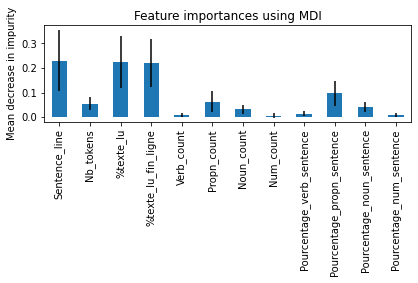

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Fin part 12